# Molecular cliffs analysis

Test the usage of Jointformer embeddings on bioactivity prediction task considering bioactivity cliffs.

This notebook utilizes MoleculeACE package: https://github.com/molML/MoleculeACE.

In [1]:
import copy
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from MoleculeACE import Data, Descriptors, get_benchmark_config, calc_rmse, calc_cliff_rmse
from MoleculeACE import SVM as MoleculeACE_SVM
from MoleculeACE import KNN as MoleculeACE_KNN

from jointformer.configs.model import ModelConfig
from jointformer.models.auto import AutoModel
from jointformer.configs.task import TaskConfig
from jointformer.utils.tokenizers.auto import AutoTokenizer

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-09 09:42:35.090798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 09:42:35.117408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 09:42:35.117495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 09:42:35.135037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to

## Utils

In [2]:
def compute_embeddings(inputs, model, embedding_func, tokenizer, batch_size=32, **tokenizer_call_kwargs):
    """Compute embeddings in batches."""
    embeddings = []
    for i in range(0, len(inputs), batch_size):
        inputs_batch = tokenizer(inputs[i:i + batch_size], **tokenizer_call_kwargs)
        embeddings_batch = embedding_func(model, inputs_batch).detach()
        embeddings.append(embeddings_batch)
    return torch.cat(embeddings)

def evaluate_regression(y_true, y_pred):
    """Evaluate regression predictions."""
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    pearson = pearsonr(y_true, y_pred)[0]
    spearman = spearmanr(y_true, y_pred)[0]
    return {
        "rmse": rmse,
        "pearson": pearson,
        "spearman": spearman,
    }

## Load MoleculeACE datasets info


In [3]:
# Load all datasets from the MoleculeACE package
datasets_list_df = pd.read_csv('https://github.com/molML/MoleculeACE/blob/main/MoleculeACE/Data/benchmark_data/metadata/datasets.csv?raw=true')

print(datasets_list_df.shape)
datasets_list_df.head()

(30, 15)


,Dataset,ChEMBL ID,Target name,Abbriviation,Type,Receptor Class,Compounds,Cliff compounds,Percentage cliffs,Train compounds,Train cliff compounds,Percentage train cliffs,Test compounds,Test cliff compounds,Percentage test cliffs
0,CHEMBL1871_Ki,CHEMBL1871,Androgen Receptor,AR,Ki,NR,659,157,24,525,126,24,134,31,23
1,CHEMBL218_EC50,CHEMBL218,Cannabinoid receptor 1,CB1,EC50,GPCR,1031,367,36,823,292,35,208,75,36
2,CHEMBL244_Ki,CHEMBL244,Coagulation factor X,FX,Ki,Protease,3097,1350,44,2476,1080,44,621,270,43
3,CHEMBL236_Ki,CHEMBL236,Delta opioid receptor,DOR,Ki,GPCR,2598,965,37,2077,772,37,521,193,37
4,CHEMBL234_Ki,CHEMBL234,Dopamine D3 receptor,D3R,Ki,GPCR,3657,1441,39,2923,1150,39,734,291,40


## Multiple datasets modeling

### Setup Jointformer

In [4]:
PATH_TO_TASK_CONFIG = '../../configs/tasks/guacamol/physchem/'
PATH_TO_MODEL_CONFIG = '../../configs/models/jointformer/'
PATH_TO_PRETRAINED_MODEL = "../../../../checkpoints/lm_physchem/ckpt.pt"

task_config = TaskConfig.from_config_file(PATH_TO_TASK_CONFIG)
task_config.path_to_vocabulary = "../../data/vocabularies/deepchem.txt"

# Get tokenizer
tokenizer = AutoTokenizer.from_config(task_config)

# Load the model
model_config = ModelConfig.from_config_file(PATH_TO_MODEL_CONFIG)
jointformer = AutoModel.from_config(model_config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load weights
jointformer.load_pretrained(PATH_TO_PRETRAINED_MODEL)

jointformer.eval()
jointformer.to(device)

# Define embeddings function
embeddings_func = lambda model, inputs: model(**inputs)["embeddings"].mean(1)

### Iterate over datasets and compare ML models with Jointformer embeddings with best model and representations from paper

In [5]:
# Define hparams grid for traditional ML models - same grids as in MoleculeACE paper
per_model_hyperparameters_grid = {
    "knn": {
        "n_neighbors": [1, 3, 11, 21],
        "metric": ["cosine", "euclidean"]
    },
    "svm": {
        "C": [1, 10, 100, 1000, 10000],
        "gamma": [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
    }
}

In [6]:
# Initialize results 
results = {
    "dataset": [],
    "model": [],
    "test_rmse": [],
    "test_cliff_rmse": [],
}

# Iterate over all datasets
for dataset in datasets_list_df["Dataset"].unique():
    # Load data
    raw_data = Data(dataset)

    # Compute embeddings
    X_train_jointformer_embeddings = compute_embeddings(raw_data.smiles_train, jointformer, embeddings_func, tokenizer, batch_size=2)
    X_train_jointformer_embeddings = X_train_jointformer_embeddings.cpu().numpy()

    X_test_jointformer_embeddings = compute_embeddings(raw_data.smiles_test, jointformer, embeddings_func, tokenizer, batch_size=2)
    X_test_jointformer_embeddings = X_test_jointformer_embeddings.cpu().numpy()

    ### Model with svm and jointformer embeddings
    model = SVR(kernel="rbf")

    # Grid search
    grid_search = GridSearchCV(model, per_model_hyperparameters_grid["svm"], scoring="neg_mean_squared_error", n_jobs=2, cv=5)
    grid_search.fit(X_train_jointformer_embeddings, raw_data.y_train)

    # Evaluate
    y_pred = grid_search.best_estimator_.predict(X_test_jointformer_embeddings)
    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("svm_jointformer")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model with knn and jointformer embeddings
    model = KNeighborsRegressor()

    # Grid search
    grid_search = GridSearchCV(model, per_model_hyperparameters_grid["knn"], scoring="neg_mean_squared_error", n_jobs=2, cv=5)
    grid_search.fit(X_train_jointformer_embeddings, raw_data.y_train)

    # Evaluate
    y_pred = grid_search.best_estimator_.predict(X_test_jointformer_embeddings)
    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("knn_jointformer")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model from the MoleculeACE package - SVM with ECFP fingerprints
    algorithm = MoleculeACE_SVM
    
    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("svm_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model from the MoleculeACE package - KNN with ECFP fingerprints
    algorithm = MoleculeACE_KNN
    
    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("knn_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

results_df = pd.DataFrame(results)

## Display the results

In [7]:
print(results_df.shape)

results_df.head()

(120, 4)


,dataset,model,test_rmse,test_cliff_rmse
0,CHEMBL1871_Ki,svm_jointformer,0.812010,1.036033
1,CHEMBL1871_Ki,knn_jointformer,0.847621,1.165791
2,CHEMBL1871_Ki,svm_ecfp,0.664931,0.873356
3,CHEMBL1871_Ki,knn_ecfp,0.649790,0.817006
4,CHEMBL218_EC50,svm_jointformer,0.761406,0.819545


In [8]:
# Aggregate results over models
results_agg_df = results_df.groupby("model").agg({
    "test_rmse": ["mean", "std"],
    "test_cliff_rmse": ["mean", "std"],
})
results_agg_df

test_rmse           test_cliff_rmse          
                     mean       std            mean       std
model                                                        
knn_ecfp         0.728975  0.095928        0.838777  0.093639
knn_jointformer  0.884553  0.122473        0.928047  0.123543
svm_ecfp         0.671198  0.079625        0.751129  0.095433
svm_jointformer  0.784181  0.110780        0.864499  0.114079

/tmp/ipykernel_117032/753014347.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="model", y="test_rmse", ax=ax[0], palette=p)
/tmp/ipykernel_117032/753014347.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="model", y="test_cliff_rmse", ax=ax[1], palette=p)


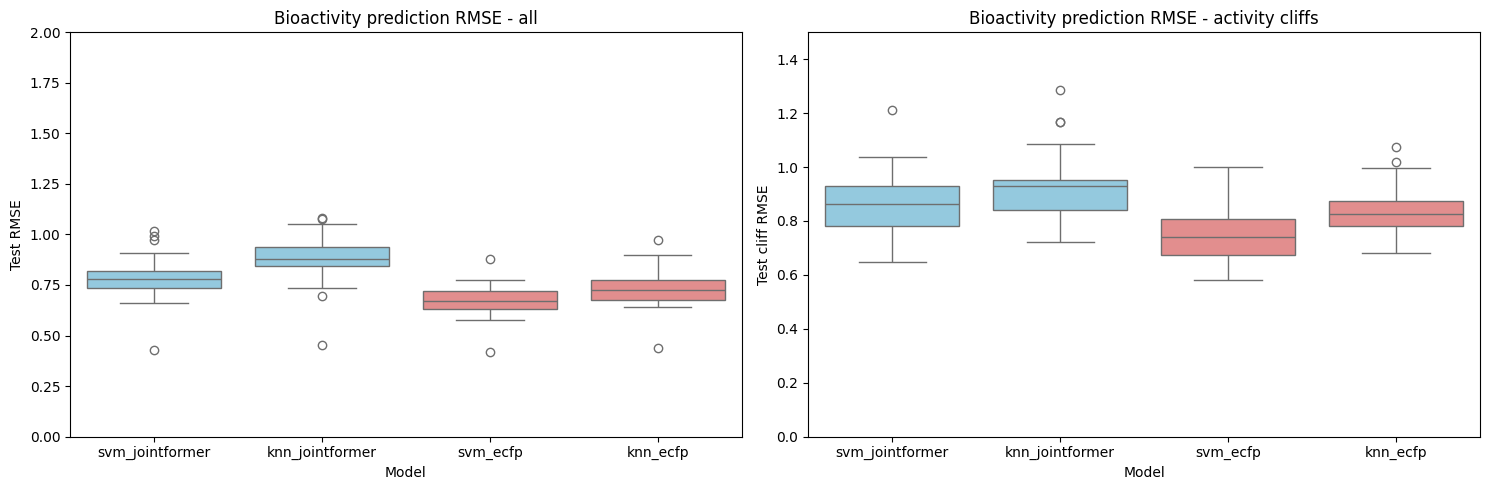

In [14]:
# Boxplot of the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Define your custom palette
p = {
    "svm_jointformer": "skyblue",
    "knn_jointformer": "skyblue",
    "svm_ecfp": "lightcoral",
    "knn_ecfp": "lightcoral",

}

sns.boxplot(data=results_df, x="model", y="test_rmse", ax=ax[0], palette=p)
ax[0].set_title("Bioactivity prediction RMSE - all")
ax[0].set_ylabel("Test RMSE")
ax[0].set_xlabel("Model")
# Same scale on y-axis
ax[0].set_ylim(0, 2)

sns.boxplot(data=results_df, x="model", y="test_cliff_rmse", ax=ax[1], palette=p)
ax[1].set_title("Bioactivity prediction RMSE - activity cliffs")
ax[1].set_ylabel("Test cliff RMSE")
ax[1].set_xlabel("Model")
# Same scale on y-axis
ax[1].set_ylim(0, 1.5)

plt.tight_layout()
plt.show()